In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
%env SOCIALMEDIAIE_PATH /content/gdrive/My Drive/SocialMediaIE/

env: SOCIALMEDIAIE_PATH=/content/gdrive/My Drive/SocialMediaIE/


In [4]:
%%bash
echo "${SOCIALMEDIAIE_PATH}"
pip install -e "${SOCIALMEDIAIE_PATH}"

/content/gdrive/My Drive/SocialMediaIE/
Obtaining file:///content/gdrive/My%20Drive/SocialMediaIE
  Running setup.py develop for SocialMediaIE


In [2]:
! ls "${SOCIALMEDIAIE_PATH}/data/processed"

ABUSIVE  CHUNKING  NER	POS  SENTIMENT	SUPERSENSE  UNCERTAINITY


In [3]:
%%bash 
echo "${SOCIALMEDIAIE_PATH}"
ls -ltrh "${SOCIALMEDIAIE_PATH}/data"
realpath "${SOCIALMEDIAIE_PATH}"
cd "${SOCIALMEDIAIE_PATH}" && ls -ltrh

/content/gdrive/My Drive/SocialMediaIE/
total 27K
drwx------  9 root root 4.0K Apr 18 00:33 processed
drwx------ 83 root root 4.0K Apr 18 01:08 models
-rw-------  1 root root 2.8K Apr 18 03:18 cleanup_model_folders.py
-rw-------  1 root root  12K Apr 18 03:18 databank_api_client_v3.py
drwx------ 41 root root 4.0K May 17 15:01 models_classification
/content/gdrive/My Drive/SocialMediaIE
total 63K
-rw-------  1 root root 1.6K Apr 18 00:33 TODO.md
drwx------ 10 root root 4.0K Apr 18 00:33 SocialMediaIE
-rw-------  1 root root  901 Apr 18 00:33 README.md
-rw-------  1 root root  12K Apr 18 00:33 LICENSE
drwx------  5 root root 4.0K Apr 18 00:33 data
drwx------  4 root root 4.0K Apr 18 00:33 tests
drwx------  2 root root 4.0K Apr 18 00:33 temp
-rw-------  1 root root   71 Apr 18 00:33 run_tests.sh
-rw-------  1 root root   71 Apr 18 00:33 run_tests.cmd
drwx------  2 root root 4.0K Apr 18 00:33 notebooks
drwx------  2 root root 4.0K Apr 18 00:33 experiments
-rw-------  1 root root  350 Apr 1

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import warnings
import os

from SocialMediaIE.data.tokenization import tokenize

In [0]:
sns.set_context("talk")
sns.set_style("ticks")
np.random.seed(1337)
warnings.simplefilter("ignore")

In [0]:
def process_token(token):
    token = token.lower()
    if token.startswith("@"):
        return "@USER"
    if token.startswith("#"):
        return "#HASHTAG"
    if token.startswith(("http://", "https://", "www.")):
        return "http://URL.COM"
    return token

def preprocess_text(text):
    tokens = [process_token(token) for token in tokenize(text)]
    return " ".join(tokens)
  
DATA_KEY="Airline"
SOCIALMEDIAIE_PATH="/content/gdrive/My Drive/SocialMediaIE/"
CATEGORIES=["negative", "neutral", "positive"]

def read_data(split_key):
  df = pd.read_json(f"{SOCIALMEDIAIE_PATH}/data/processed/SENTIMENT/{DATA_KEY}/{split_key}.json", orient="records", lines=True)
  df["text"] = df["text"].apply(preprocess_text)
  df["label"] = pd.Categorical(df["label"], categories=CATEGORIES)
  return df

In [7]:
%%time
df_train = read_data("train")
df_dev = read_data("dev")
df_test = read_data("test")

df_train.head()

CPU times: user 1.4 s, sys: 29.6 ms, total: 1.43 s
Wall time: 1.44 s


# Train model

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.backend as K

W0522 20:32:38.044125 140548309415808 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [9]:
tf.__version__, np.__version__

('1.13.1', '1.16.3')

In [10]:
num_labels = len(CATEGORIES)
print(f"Size: train: {df_train.shape}, dev: {df_dev.shape}, test: {df_test.shape}, {num_labels} labels")

Size: train: (8825, 3), dev: (981, 3), test: (2452, 3), 3 labels


In [0]:
def get_X_y(df):
  X = df.text.values[:, np.newaxis]
  y = np.zeros((df.shape[0], df.label.cat.categories.shape[0]))
  y[:, df.label.cat.codes] = 1
  print(X.shape, y.shape)
  return X, y



def get_model_output(X, model, index=None, scoring=stats.entropy):
  output = model.predict(X, batch_size=32)
  df_output = pd.DataFrame(output, columns=CATEGORIES, index=index)
  df_output["predicted"] = df_output.idxmax(axis=1)
  df_output["predicted"] = pd.Categorical(df_output["predicted"], categories=CATEGORIES)
  
  selection_scores = scoring(output.T)
  df_output["selection_scores"] = selection_scores
  return df_output


def classification_metrics(df_output, true_labels):
    predicted_labels = df_output["predicted"]
    report = pd.DataFrame(classification_report(true_labels, predicted_labels, output_dict=True)).T
    cm = confusion_matrix(true_labels, predicted_labels)
    cm = pd.DataFrame(cm, columns=CATEGORIES, index=CATEGORIES)
    return cm, report
  

In [12]:
X_train, y_train = get_X_y(df_train)
X_dev, y_dev = get_X_y(df_dev)
X_test, y_test = get_X_y(df_test)

(8825, 1) (8825, 3)
(981, 1) (981, 3)
(2452, 1) (2452, 3)


In [0]:
class ElmoEmbeddingLayer(tf.keras.layers.Layer):
    """Taken from: 
    https://github.com/strongio/keras-elmo/blob/master/Elmo%20Keras.ipynb"""
    def __init__(self, output_key="default", **kwargs):
        self.dimensions = 1024
        self.signature = "default"
        self.output_key = output_key
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module(
            'https://tfhub.dev/google/elmo/2', 
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        if self.trainable:
          self._trainable_weights.extend(
              tf.trainable_variables(scope="^{}_module/.*".format(self.name))
          )
        # Changed assuming trainable weights might be set using 
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(
            K.squeeze(K.cast(x, tf.string), axis=1),
            as_dict=True,
            signature=self.signature,
        )[self.output_key]
        return result

    def compute_mask(self, inputs, mask=None):
        if self.signature == "default":
          # Mask only supported for non default case.
          return None
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        if self.output_key in {"elmo", "word_emb", "lstm_outputs1", "lstm_outputs2"}:
          tf.Print(f"Inside elmo compute_output_shape {input_shape}")
          return (input_shape[0], None, self.dimensions)
        else:
          return (input_shape[0], self.dimensions)

        
def create_model(num_labels=2, hidden_dims=100, train_elmo=False):
  # Create Sequential model
  model = tf.keras.Sequential([
      # Need to explicitly include input layer 
      # to allow keras to accept string input
      # Taken from:
      # https://gist.github.com/colinmorris/9183206284b4fe3179809098e809d009
      tf.keras.layers.InputLayer(dtype='string', input_shape=(1,)),
      ElmoEmbeddingLayer(trainable=train_elmo, output_key="default"),
      tf.keras.layers.Dense(hidden_dims, activation="relu"),
      tf.keras.layers.Dense(num_labels, activation="softmax")
  ])
  
  # Needed to initialize elmo variables
  sess = K.get_session()
  init = tf.global_variables_initializer()
  sess.run(init)
  
  # Compile model
  model.compile(
      optimizer="adam",
      loss="categorical_crossentropy",
      metrics=[
          "accuracy",
          tf.keras.metrics.Precision(),
          tf.keras.metrics.Recall(),
          tf.keras.metrics.FalseNegatives(),
          tf.keras.metrics.FalsePositives(),
          tf.keras.metrics.TrueNegatives(),
          tf.keras.metrics.TruePositives()
      ]
  )
  return model




In [16]:
K.clear_session()
model = create_model(num_labels=num_labels, hidden_dims=10, train_elmo=False)
csv_logger = tf.keras.callbacks.CSVLogger('training.log')
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=1e-3)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


W0522 20:33:00.326464 140548309415808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0522 20:33:01.031336 140548309415808 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
elmo_embedding_layer (ElmoEm (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 10,283
Trainable params: 10,283
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(1024, 10) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(10, 3) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(3,) dtype=float32>]

In [18]:
model.predict(X_train[:10]).shape

(10, 3)

In [0]:
SEED_SIZE=1000
selected_indexes = np.random.choice(df_train.index, size=SEED_SIZE, replace=False)

In [20]:
df_train["selected"] = False
df_train.loc[selected_indexes, "selected"] = True

train_metrics = []
dev_metrics = []
test_metrics = []
training_indexes = selected_indexes
ANNOTATIONS_PER_STEP=100
MAX_ITERATIONS=10
scoring_fn=stats.entropy
score_sort_ascending=False

for i in range(MAX_ITERATIONS):
    print(f"Starting iteration {i}")
    # Identifiy selected data
    df_selected = df_train[df_train.selected]
    df_unselected = df_train[~df_train.selected]
    # Fit model
    X_selected, y_selected = get_X_y(df_selected)
    X_unselected, y_unselected = get_X_y(df_unselected)
    model.fit(
        X_selected, y_selected, 
        validation_data=(X_dev, y_dev),
        batch_size=32, 
        epochs=5,
        callbacks=[csv_logger, early_stopping]
    )
    # Get model metrics
    # Unselected training data
    %time df_output = get_model_output(X_unselected, model, index=df_unselected.index, scoring=scoring_fn)
    cm, cr = classification_metrics(df_output, df_unselected.label)
    train_metrics.append((cm, cr))
    
    # Select instances
    new_indexes = df_output.sort_values("selection_scores", ascending=score_sort_ascending).head(ANNOTATIONS_PER_STEP).index
    print(f"Selected data distribution: {df_unselected.loc[new_indexes].label.value_counts().to_dict()}")
    # Add these instances to the training data
    training_indexes = np.hstack([training_indexes, new_indexes])
    df_train.loc[new_indexes, "selected"] = True
    print(f"Total training size: {df_train[df_train.selected].shape[0]}")
    
    
    # Dev data
    %time df_output = get_model_output(X_dev, model, index=df_dev.index, scoring=scoring_fn)
    cm, cr = classification_metrics(df_output, df_dev.label)
    dev_metrics.append((cm, cr))
    # Test data
    %time df_output = get_model_output(X_test, model, index=df_test.index, scoring=scoring_fn)
    cm, cr = classification_metrics(df_output, df_test.label)
    test_metrics.append((cm, cr))

Starting iteration 0
(1000, 1) (1000, 3)
(7825, 1) (7825, 3)
Train on 1000 samples, validate on 981 samples
Instructions for updating:
Use tf.cast instead.


W0522 20:33:12.331382 140548309415808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/5
1000/1000 [==============================] - 13s 13ms/sample - loss: 3.3026 - acc: 0.1830 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_negatives: 3000.0000 - false_positives: 0.0000e+00 - true_negatives: 0.0000e+00 - true_positives: 0.0000e+00 - val_loss: 3.2959 - val_acc: 0.0041 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_negatives: 2943.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 0.0000e+00 - val_true_positives: 0.0000e+00
Epoch 2/5
1000/1000 [==============================] - 10s 10ms/sample - loss: 3.2958 - acc: 0.0030 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_negatives: 3000.0000 - false_positives: 0.0000e+00 - true_negatives: 0.0000e+00 - true_positives: 0.0000e+00 - val_loss: 3.2958 - val_acc: 0.0020 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_negatives: 2943.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 0.0000e+00 - val_true_positives: 0.0000e+00
CPU times: user 41.9 s, sys: 7

In [0]:
def plot_metrics(metrics, key="f1-score", base_metric=None):
    df_metrics = pd.concat([
        iter_metrics[1][key].to_frame().T.melt(var_name="metric").assign(iteration=i)
        for i, iter_metrics in enumerate(metrics)
    ], axis=0)
    g = sns.FacetGrid(df_metrics, col="metric", sharey=False)
    g.map(plt.plot, "iteration", "value", marker=".")
    if base_metric is not None:
        for ax, c in zip(g.axes.flatten(), g.col_names):
            ax.axhline(y=base_metric[1].loc[c, key], color="k", linestyle="--")
    return df_metrics

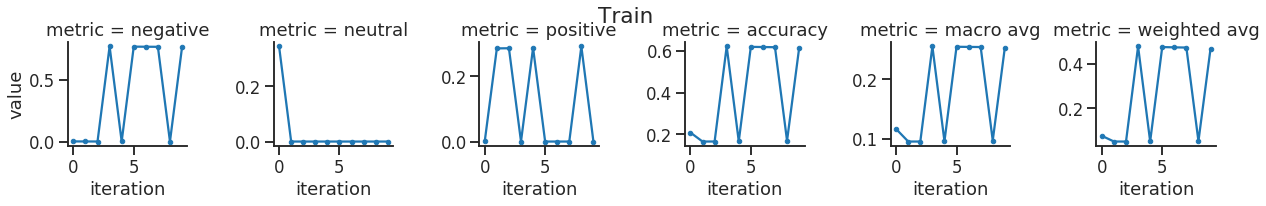

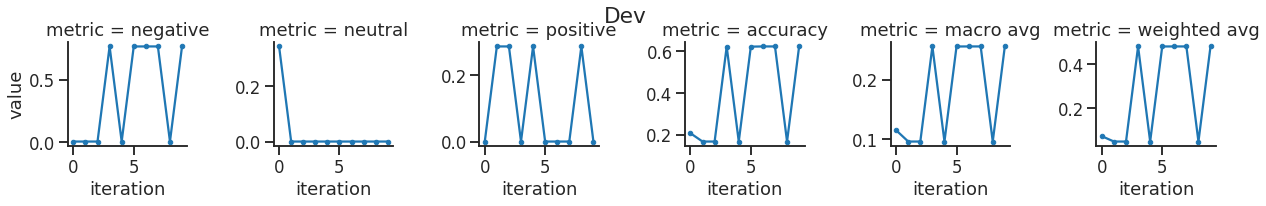

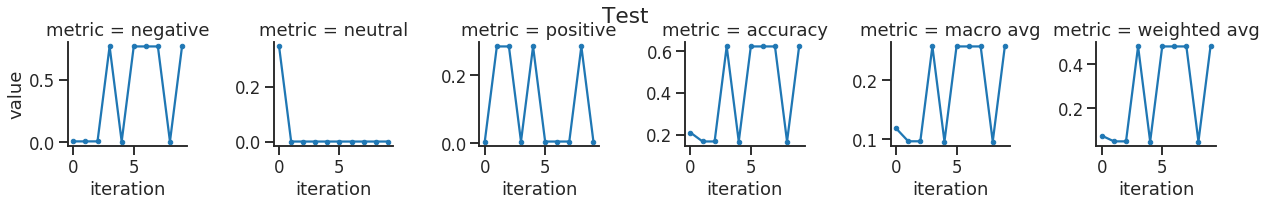

In [22]:
plot_metrics(train_metrics);
plt.suptitle("Train");
plot_metrics(dev_metrics);
plt.suptitle("Dev");
plot_metrics(test_metrics);
plt.suptitle("Test");